# Rozpoznawanie ręcznie pisanych cyfr za pomocą PyTorch

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# dodanie tej linii może być konieczne, gdy nie mamy uprawnień administratora
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Wczytanie i przygotowanie danych

Pracę rozpoczniemy od pobrania zbioru MNIST, zawierającego 70 tyś. przykładów ręcznie pisanych cyfr 0-9 w formie obrazków 28x28 pikseli. Wykorzystamy w tym celu klase `MNIST` z modułu torchvision.

In [3]:
from torchvision.datasets import MNIST

target_directory = "mnist"

mnist_train = MNIST(target_directory, train=True, download=True)
mnist_test = MNIST(target_directory, train=False, download=True)

100.0%
100.0%
100.0%
100.0%


Wczytaliśmy dwa zbiory danych, zbadajmy ich długość

In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

Pojedynczy element `mnist_train` składa się z pary: obrazek oraz jego etykieta

In [5]:
mnist_train[0][0]

In [6]:
mnist_train[0][1]

5

Sprawdźmy rozmiar obrazka

In [7]:
mnist_train[0][0].size

(28, 28)

Niestety, tak wczytane obrazki są - no właśnie - obrazkami, a nie macierzami liczb. Wczytamy je ponownie, ale tym razem zamieniając je od razu na dwuwymiarowe tensory (obiekty klasy `torch.Tensor`). Tensor to uogólnienie macierzy na więcej niż dwa wymiary (czyli wielowymiarowa tablica liczb).

In [8]:
import torchvision.transforms as transforms

def flatten(inp):
    return inp.reshape(-1)

transform = transforms.Compose([transforms.ToTensor(), flatten])

mnist_train = MNIST(target_directory, train=True, download=True, transform=transform)
mnist_test = MNIST(target_directory, train=False, download=True, transform=transform)

Zbadajmy typ i rozmiar tensora reprezentującego pierwszy obiekt w zbiorze uczącym

In [9]:
type(mnist_train[0][0]), mnist_train[0][0].shape

(torch.Tensor, torch.Size([784]))

Podzielimy zbiór uczący na dwie części: faktyczny zbiór uczący o rozmiarze $80\%\cdot 60000=48000$ i zbiór walidujący o rozmiarze $20\%\cdot 60000=12000$

In [10]:
mnist_train, mnist_validation = data.random_split(mnist_train, (48000, 12000))
len(mnist_train), len(mnist_validation)

(48000, 12000)

## Regresja logistyczna

PyTorch opiera się na modułach (obiektach klasy `torch.nn.Module`), które są wkomponowane w graf obliczeń. Każdy z modułów może wykorzystywać parametry (obiekty klasy `torch.nn.Parameter`), dla których mogą być automatycznie liczone gradienty i które (potencjalnie) podlegają optymalizacji.

Rozpoczynamy od skonstruowania pojedynczej warstwy liniowej - tj. warstwy implementującej operację $\hat{y} = Wx + b$

Stworzymy prosty model regresji logistycznej, uczony na surowych pikselach obrazków. Macierz wag cech (tutaj: pikseli obrazu) będzie typu $p\times k$ (tzn. $p$ wag dla każdej z $k$ klas). Model będzie obliczał logits, tzn. wyjście regresji logistycznej **przed** zastosowaniem funkcji softmax: każdy wiersz odpowiada jednemu przykładowi trenującemu dla zadanego X, a każda kolumna jednej z klas. Gdyby każdy z wierszy unormować funkcją softmax, to w kolejnych wierszach byłyby wektory prawdopodobieństw, przynależności obiektu do danej klasy.

In [11]:
p = 28*28 #obrazki mają rozmiar 28x28 pikseli
k = 10 #jest 10 klas - cyfry 0..9

model = nn.Linear(p, k)

Jako miarę do optymalizacji będziemy wykorzystywali entropię krzyżową (ang. *cross entropy*), a do optymalizacji wykorzystamy optymalizator *Adam*. Chcemy, żeby parametry `W` oraz `b` automatycznie się zoptymalizowały w procesie uczenia. Wykorzystamy w tym celu klasę `torch.optim.Adam`, która implementuje pewne ulepszenie algorytmu Gradient Descent. Tworzymy obiekt `opt`, który będzie odpowiedzialny za optymalizację parametrów regresora, uzyskanych przez wywołanie `model.parameters()`

In [12]:
cost = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters())

Przygotowujemy funkcję pomocniczą do liczenia trafności klasyfikacji (ang. *accuracy*). W każdym wierszu `logits` wybieramy numer kolumny z największą wartością, porównujemy z wartością oczekiwaną i tak uzyskane wartości (0 lub 1) uśredniamy po przykładach w celu uzyskania trafności klasyfikacji.

In [13]:
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

## Uruchomienie obliczeń


Zaimplementujemy uczenie mini-batch przez `n_epoch` epok. W ramach każdej z epok:
1. Tworzymy pomocniczy obiekt `loader` klasy `DataLoader`, który dzieli zbiór `mnist_train` na paczki (ang. *batch*) rozmiaru `batch_size`, w których kolejność obiektów jest losowana.
3. Zerujemy gradienty zapamiętane przez optymalizator (`opt.zero_grad()`)
4. Uruchamiamy regresor, obliczamy błąd
5. Obliczamy gradienty (`backward()`)
6. Modyfikujemy wagi aplikując poprawki wyznaczone przez obliczone gradienty (`opt.step()`)
7. Zapamiętujemy wartość entropii krzyżowej. Wywołujemy metodę `detach()`, żeby zapamiętana wartość nie była powiązana ze swoimi gradientami.

Po wykonaniu epoki uśredniamy zebrane wartości entropi i zapamiętujęmy tę wartość

In [19]:
loss_values = []
acc_values = []
batch_size = 128
n_epoch = 5

In [20]:
for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y)
    acc_values.append(acc)

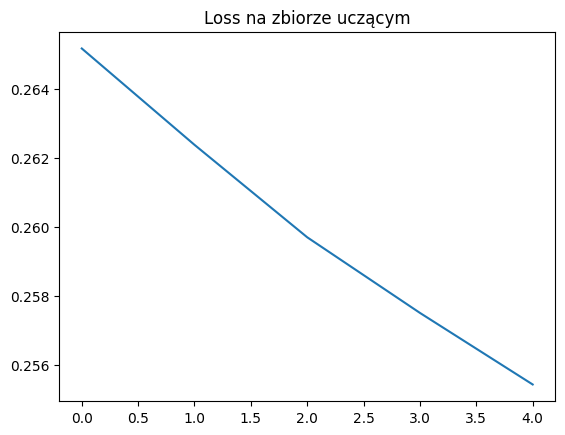

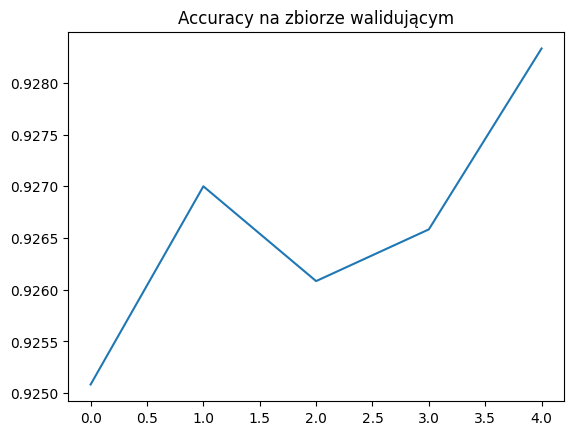

In [21]:
plt.title("Loss na zbiorze uczącym")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy na zbiorze walidującym")
plt.plot(acc_values)
plt.show()

Uruchom ponownie powyższe trzy komórki z kodem. Ponieważ klasyfikator i optymalizator ciągle reprezentują te same obiekty, więc już nauczone wartości parametrów są pamiętane i wykres wygląda zupełnie inaczej. Żeby powrócić do stanu początkowego trzeba stworzyć na nowo obiekty `model` i `opt`.

## Sieć neuronowa z jedną warstwą ukrytą

Regresja logistyczna to wariant sieci neuronowej bez warstw ukrytych. Wykorzystaj powyższy kod i rozszerz go o warstwę ukrytą o h=500 neuronach. Żeby połączyć kilka obiektów typu `torch.nn.Module` w sekwencję wykorzystaj klasę `torch.nn.Sequential`. Do implementacji nieliniowości między warstwami wykorzystaj funkcję LeakyReLU implementowaną przez klasę `torch.nn.LeakyReLU`

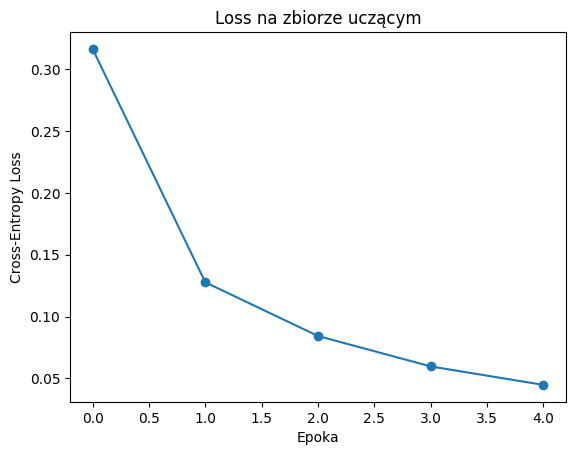

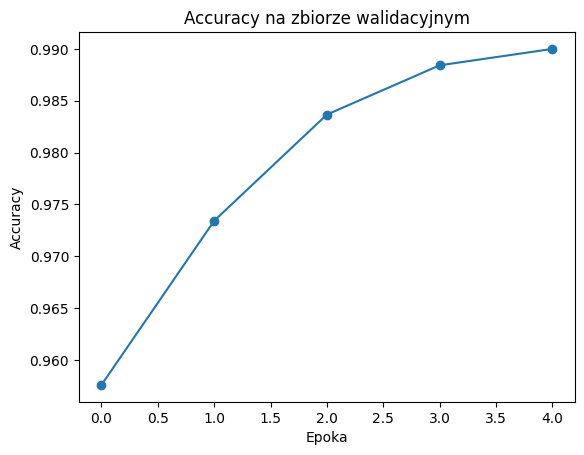

In [25]:
# Tu kod, może być w więcej niż jednej komórce

def flatten(inp):
    return inp.reshape(-1)

transform = transforms.Compose([transforms.ToTensor(), flatten])

mnist_train = MNIST(target_directory, train=True, download=True, transform=transform)
mnist_test = MNIST(target_directory, train=False, download=True, transform=transform)

p = 28 * 28  # rozmiar wejścia
k = 10  # liczba klas
h = 500  # liczba neuronów w warstwie ukrytej

model = nn.Sequential(
    nn.Linear(p, h),  # warstwa wejściowa
    nn.ReLU(),  # funkcja aktywacji ReLU
    nn.Linear(h, k)  # warstwa wyjściowa
)
cost = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

n_epoch = 5
batch_size = 128
loss_values = []
acc_values = []

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X)
    acc = compute_acc(logits, y)
    acc_values.append(acc)
    
import matplotlib.pyplot as plt
plt.figure()
plt.title("Loss na zbiorze uczącym")
plt.plot(loss_values, marker='o')
plt.xlabel("Epoka")
plt.ylabel("Cross-Entropy Loss")
plt.show()

plt.figure()
plt.title("Accuracy na zbiorze walidacyjnym")
plt.plot(acc_values, marker='o')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.show()


Zaimplementuj uczenie sieci z warstwą ukrytą przez 10 epok. W trakcie uczenia zbieraj wartości straty i accuracy zarówno na zbiorze uczącym, jak i na zbiorze walidującym, a następnie narysuj je na wykresach (dwa wykresy każdy z dwoma krzywymi).

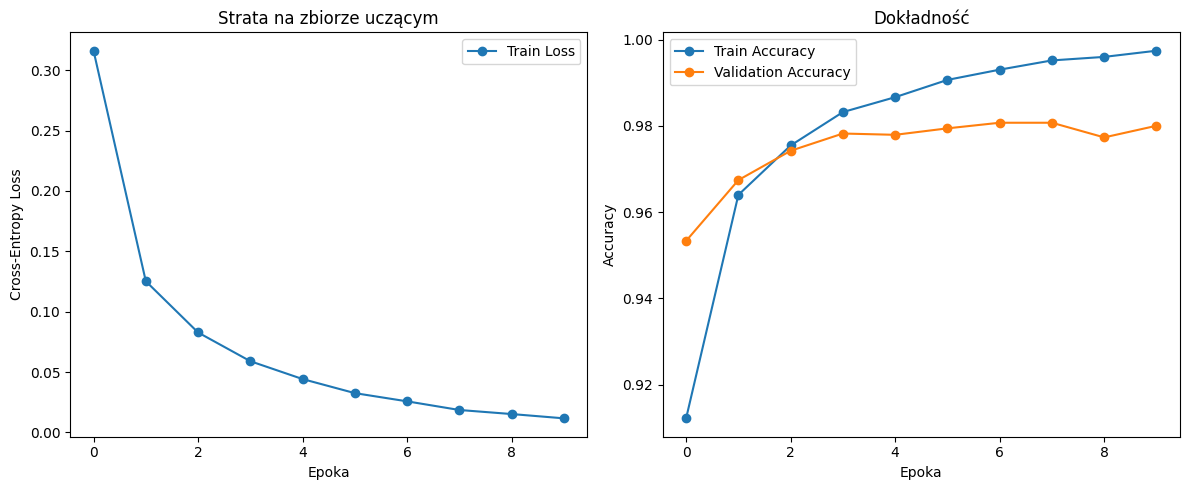

In [ ]:
# Tu kod, może być w więcej niż jednej komórce

def flatten(inp):
    return inp.reshape(-1)

transform = transforms.Compose([transforms.ToTensor(), flatten])

target_directory = "mnist"
mnist_train = MNIST(target_directory, train=True, download=True, transform=transform)
mnist_val = MNIST(target_directory, train=False, download=True, transform=transform)

# Parametry
p = 28 * 28  # wejście
k = 10       # liczba klas
h = 500      # ukryta warstwa

# Model
model = nn.Sequential(
    nn.Linear(p, h),
    nn.ReLU(),
    nn.Linear(h, k)
)

cost = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-3)

def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).float().mean()

n_epoch = 10
batch_size = 128
loss_values = []
train_acc_values = []
val_acc_values = []

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    
    epoch_loss = []
    epoch_acc = []
    
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch)
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()
        acc = compute_acc(logits, y_batch)
        epoch_loss.append(loss.item())
        epoch_acc.append(acc.item())
    
    loss_values.append(sum(epoch_loss) / len(epoch_loss))
    train_acc_values.append(sum(epoch_acc) / len(epoch_acc))
    model.eval()
    with torch.no_grad():
        val_loader = data.DataLoader(mnist_val, batch_size=len(mnist_val), shuffle=False)
        X_val, y_val = next(iter(val_loader))
        logits_val = model(X_val)
        acc_val = compute_acc(logits_val, y_val)
        val_acc_values.append(acc_val.item())

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label="Train Loss", marker='o')
plt.xlabel("Epoka")
plt.ylabel("Cross-Entropy Loss")
plt.title("Strata na zbiorze uczącym")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_values, label="Train Accuracy", marker='o')
plt.plot(val_acc_values, label="Validation Accuracy", marker='o')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.title("Dokładność")
plt.legend()

plt.tight_layout()
plt.show()
